In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import arviz as az
import jax
import jax.experimental
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel, UniformTSubspace
from src.jax_test_model import MLPModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t, setup_inference_chain
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree, matrix_to_pytree, pytree_to_vec, vec_to_single_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm
from src.utils import get_cp_w, get_data, get_samples_from_run, get_model_from_run_path
from src.jax_subspace_curve import bezier_coeff_fn


%load_ext autoreload
%autoreload 2

%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [2]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### load data

Data shapes: (56, 1) (56,) (33, 1) (33,)


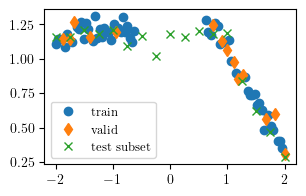

In [3]:
# load data
data = jnp.load('regression_data.npz')
x = jnp.array(data['x'])
y = jnp.array(data['y'])
x_test_ = jnp.array(data['xt'])
y_test_ = jnp.array(data['yt'])
# Split the data into training and validation sets
random_idx = jax.random.choice(random.PRNGKey(
    0), x.shape[0], (int(x.shape[0]*0.2),), replace=False)
x_val = x[random_idx]
y_val = y[random_idx]
x = x[np.setdiff1d(jnp.arange(x.shape[0]), random_idx)]
y = y[np.setdiff1d(jnp.arange(y.shape[0]), random_idx)]

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [544]:
config = {
    'curve_params': {'k': 20,
                     'model_kwargs': {'depth': 3, 'width': 16, 'activation': 'elu'},
                     'n_samples': 10,
                     'lr': 0.001,
                     'num_epochs': 10000,
                     'use_validation': True,
                     'out_scale': 0.1,
                     'optimize_distparams': True,
                     'uniform_t_optimize': False,
                     'bias_ascending_dnn': False
                     },
    'rng_seed': 11,
    'dataset': 'generate',
}

Data shapes: (70, 1) (70,) (33, 1) (33,)


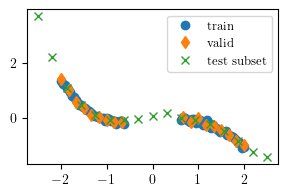

In [385]:
def gen_data(rng_seed, curve_params, **kwargs):
    rng_key = random.PRNGKey(rng_seed + 1133)
    x = jnp.linspace(-2, 2, 100)
    x = x[(jnp.abs(x) > 0.6)].reshape(-1, 1)

    # define ground trouth model
    rng_key, rng_init = random.split(rng_key)
    model_gen = MLPModel(**curve_params['model_kwargs'])
    params = model_gen.init(rng_init, x)

    # generate train data
    y_gt = model_gen.apply(params, x).squeeze()
    rng_key, rng = random.split(rng_key)
    y = y_gt + jax.random.normal(rng, y_gt.shape) * 0.05

    # generate valid data
    x_val = jnp.linspace(-2, 2, 25)
    x_val = x_val[(jnp.abs(x_val) > 0.6)].reshape(-1, 1)
    y_gt_val = model_gen.apply(params, x_val).squeeze()
    rng_key, rng = random.split(rng_key)
    y_val = y_gt_val + jax.random.normal(rng, y_gt_val.shape) * 0.05

    xt = jnp.linspace(-2.5, 2.5, 33).reshape(-1, 1)
    rng_key, rng = random.split(rng_key)
    y_gtt = model_gen.apply(params, xt).squeeze()
    yt = y_gtt + jax.random.normal(rng, y_gtt.shape) * 0.05

    return x, y, x_val, y_val, xt, yt, y_gtt


x, y, x_val, y_val, x_test_, y_test_, _ = gen_data(**config)

plt.plot(x, y, 'o', label='train')
plt.plot(x_val, y_val, 'd', label='valid')
# Plot a subset of the test data
subset_indices = jnp.arange(0, x_test_.shape[0], 2)
plt.plot(x_test_[subset_indices], y_test_[
         subset_indices], 'x', label='test subset')
plt.legend()
print("Data shapes:", x.shape, y.shape, x_test_.shape, y_test_.shape)

In [386]:
bezier_coeff_inv = bezier_coeff_fn(config['curve_params']['k'])


def get_d_bezier(t):
    coeff = jax.vmap(bezier_coeff_inv)(t)

    def clousure(cp):
        n = cp.shape[0] - 1
        cp_diff = cp[1:] - cp[:-1]
        return jnp.einsum('tj,j...->t...', coeff, cp_diff) * n
    return clousure


@jit
def bezier_length(cp):
    t = jnp.linspace(0, 1, 1000)
    d_bezier = get_d_bezier(t)
    d_t = jnp.linalg.norm(d_bezier(cp), axis=-1)
    length = jax.scipy.integrate.trapezoid(d_t, t)
    return length

### Run Full space sampling with DE initialization

In [387]:
# import numpyro
# from jax import random

# import numpyro.distributions as dist
# import matplotlib.pyplot as plt
# import jax.numpy as jnp

# # Generate random samples from a log-normal distribution
# key = random.PRNGKey(0)
# samples = numpyro.sample('log_normal', dist.LogNormal(0., .1), sample_shape=(1000,), rng_key=key)

# # Plot the histogram of the samples
# plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# # Plot the log-normal distribution
# x = jnp.linspace(0, 1, 1000)
# pdf = jnp.exp(dist.LogNormal(-1, .5).log_prob(x))
# plt.plot(x, pdf, 'k', linewidth=2)
# plt.title('Log-Normal Distribution')
# plt.show()

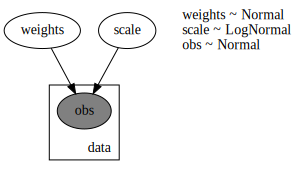

In [428]:
model = MLPModel(**config['curve_params']['model_kwargs'])
params = model.init(random.PRNGKey(0), x)

def init_full_space(model, params, prior_scale: float = 1., dist_scale: str | float = 0.05):
    n_params = pytree_to_vec(params['params']).size
    def model_full(x, y=None, temperature=1.):
        weight_vec = numpyro.sample("weights", dist.Normal(
            0., prior_scale).expand((n_params,)).to_event(1))
        if dist_scale == 'homo':
            scale = numpyro.sample("scale", dist.LogNormal(
                -1, .1))
        else:
            scale = dist_scale
        def apply_model(weight_vec, x):
            weight_pytree = vec_to_single_pytree(weight_vec, params['params'])
            out = model.apply({'params': weight_pytree}, x)
            return out
        out = apply_model(weight_vec, x)
        with numpyro.plate("data", x.shape[0], dim=-1):
            with handlers.scale(scale=1/temperature):
                numpyro.sample("obs", dist.Normal(
                    out.squeeze(-1), scale+1e-8), obs=y)
    return model_full

bayes_model = init_full_space(model, params, prior_scale=1., dist_scale="homo" if config['curve_params']['optimize_distparams'] else config['curve_params']['out_scale'])
numpyro.render_model(bayes_model, model_args=(x, y), render_distributions=True)

In [429]:
from numpyro.infer.util import initialize_model
import blackjax

num_chains = 10
temperature = 1.
num_warmup = 1000
num_draws = 1000

# generate initial values for each chain
rng_key = random.PRNGKey(2)
rng_key, init_key = jax.random.split(rng_key)


_, potential_fn, post_proc_fun, _ = initialize_model(
    init_key,
    # model_tube,
    bayes_model,
    model_args=(x, y, temperature),
    # could also set to True => potential_fn_gen(**model_args) instead of potential_fn
    dynamic_args=False,
)


def logdensity_fn(params):
    return -potential_fn(params)


In [430]:
warmup_fn, run_inference = setup_inference_chain(
    mode="VMAP", num_chains=num_chains)


def init_fn(warmup_key, initial_position, num_warmup):
    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=warmup_key
    )
    # print("Initial state:", initial_state.parameters)

    # build the kernel
    def kernel(sqrt_diag_cov):
        return blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdensity_fn,
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
            sqrt_diag_cov=sqrt_diag_cov,
        )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_warmup,
        state=initial_state,
        rng_key=warmup_key,
        diagonal_preconditioning=True,
    )
    return blackjax_state_after_tuning, blackjax_mclmc_sampler_params


def get_kernel(parameters):
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=parameters.L,
        step_size=parameters.step_size
    )
    return sampling_alg

#### DE initialized samples

In [431]:
def train(seed):
    params = model.init(random.PRNGKey(seed), x)
    params['dist_params'] =  {'log_scale': jnp.log(jnp.array(.05))}

    # train loop
    optimizer = optax.adam(learning_rate=config['curve_params']['lr'])

    # dnn_parameters + dist_parameters
    if config['curve_params']['optimize_distparams']:
        opt_state = optimizer.init(params)
    else:
        opt_state = optimizer.init(params['params'])

    @jit
    def loss_fn(params, x, y):
        out = model.apply(params, x)
        nll = -jax.scipy.stats.norm.logpdf(y,
                                           loc=out.squeeze(axis=-1), scale=jnp.exp(params['dist_params']['log_scale'])+1e-8)
        return nll.mean()

    @scan_tqdm(config['curve_params']['num_epochs'])
    def train_loop(carry, _):
        rng_key, params, opt_state, best_loss, best_params, epoch, epoch_sel = carry
        # rng_key, subkey = random.split(rng_key)

        # train
        loss, grads = jax.value_and_grad(loss_fn, argnums=0)(params, x, y)
        if config['curve_params']['optimize_distparams']:
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
        else:
            updates, opt_state = optimizer.update(
                grads['params'], opt_state, params['params'])
            params['params'] = optax.apply_updates(params['params'], updates)

        # validate
        # rng_key, subkey = random.split(rng_key)
        if config['curve_params']['use_validation']:
            val_loss = loss_fn(params, x_val, y_val)
        else:
            val_loss = loss_fn(params, x, y)
        best_params, epoch_sel = jax.lax.cond(
            val_loss < best_loss, lambda x: (params, epoch), lambda x: (best_params, epoch_sel), None)
        best_loss = jnp.minimum(best_loss, val_loss)

        return (rng_key, params, opt_state, best_loss, best_params, epoch+1, epoch_sel), (loss, val_loss, epoch)


    carry = (rng_key, params, opt_state, np.inf, params, 0, -1)
    carry, (losses, valid_losses, epochs) = jax.lax.scan(train_loop, carry,
                                                                jnp.arange(config['curve_params']['num_epochs']))
    return carry, (losses, valid_losses, epochs)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

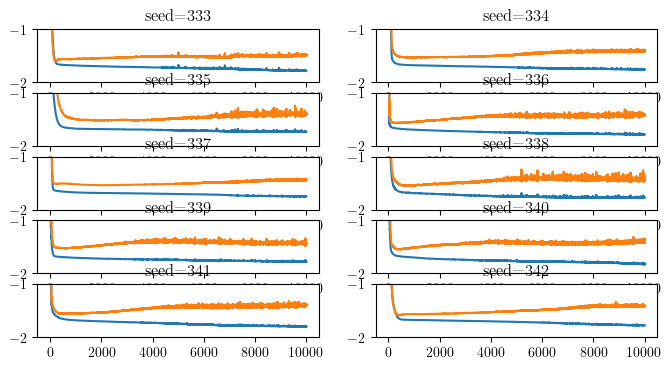

In [392]:
init_params = []
fig, axes = plt.subplots(5, 2, figsize=(8, 4))
for i, ax in enumerate(axes.flatten()):
    carry, (losses, valid_losses, epochs) = train(i+333)
    ax.plot(epochs, losses, label='train')
    ax.plot(epochs, valid_losses, label='valid')
    ax.set_ylim(-2, -1.)
    best_params = carry[4]
    init_params.append(best_params)
    ax.set_title(f"seed={i+333}")


#### run MCLMC

In [ ]:
initial_position = {}
initial_position['weights'] = jnp.array(
    [pytree_to_vec(p['params']) for p in init_params])

if config['curve_params']['optimize_distparams']:
    initial_position['scale'] = jnp.array(
        [jnp.exp(p['dist_params']['log_scale']) for p in init_params])
    # initial_position['scale'] /= 2
initial_position['scale']

Array([0.05118136, 0.05145312, 0.05074747, 0.05097051, 0.05037477,
       0.05068168, 0.04973788, 0.05038451, 0.05090092, 0.05148437],      dtype=float32)

In [433]:

wall_time, rng_key, last_state, parameters = warmup_fn(rng_key, initial_position, init_fn, num_warmup=num_warmup*50)
print("Wall time: {:.2f} s".format(wall_time))

Wall time: 6.10 s


In [434]:
wall_time, rng_key, states, infos = run_inference(
    get_kernel, rng_key, last_state, parameters, num_samples=num_draws*50)

print("Wall time: {:.2f} s".format(wall_time))

Wall time: 6.55 s


In [435]:
selected_states = jax.tree.map(
    lambda x: x[:, ::50], states.position) # to reduce autocorrelation
selected_states['weights'].shape

(10, 1000, 625)

In [436]:
posterior = jax.lax.map(lambda x: jax.vmap(post_proc_fun)(x), selected_states)
samples = az.from_dict(posterior=posterior)
summary = az.summary(samples)
summary

arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,NaN,NaN,0.105,NaN,NaN,NaN,NaN,NaN,NaN
weights[0],NaN,NaN,-3.157,NaN,NaN,NaN,NaN,NaN,NaN
weights[1],NaN,NaN,-2.981,NaN,NaN,NaN,NaN,NaN,NaN
weights[2],NaN,NaN,-3.548,NaN,NaN,NaN,NaN,NaN,NaN
weights[3],NaN,NaN,-3.555,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
weights[620],NaN,NaN,-6.492,NaN,NaN,NaN,NaN,NaN,NaN
weights[621],NaN,NaN,-6.186,NaN,NaN,NaN,NaN,NaN,NaN
weights[622],NaN,NaN,-4.684,NaN,NaN,NaN,NaN,NaN,NaN
weights[623],NaN,NaN,-6.036,NaN,NaN,NaN,NaN,NaN,NaN


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

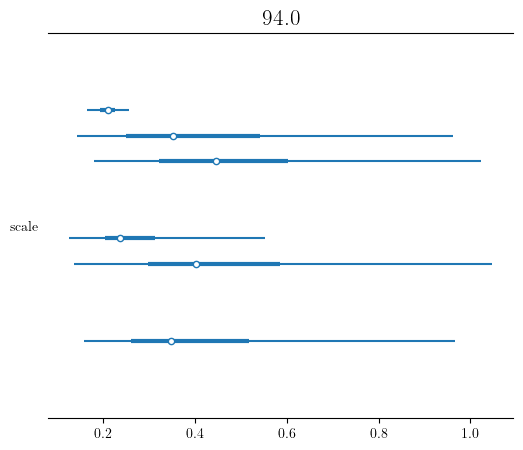

In [437]:
az.plot_forest(samples, var_names=['scale'])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

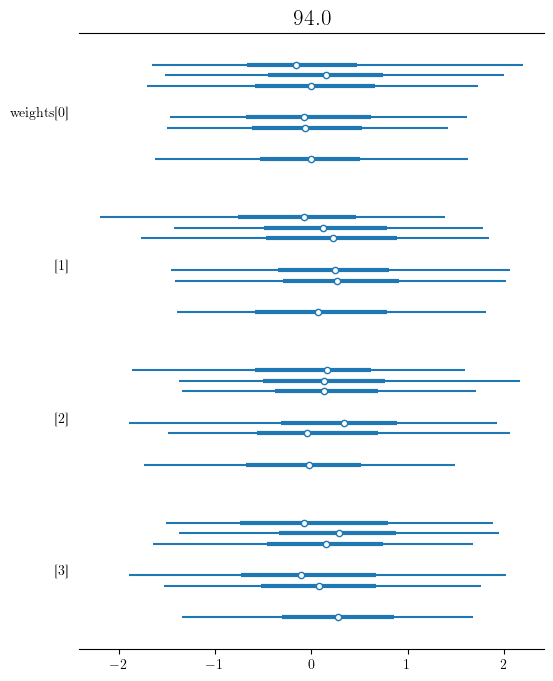

In [438]:
coords = {'weights_dim_0': jnp.arange(4)}
az.plot_forest(samples, var_names=['weights'], combined=False, coords=coords)

In [439]:
num_clean_chains = samples.posterior.dropna(
    dim='chain', how='any').chain.size
print(f"Num clean chains: {num_clean_chains}")
if num_clean_chains == 0:
    print(f"No chains left")

clean_samples = az.InferenceData(posterior=samples.posterior.dropna(dim='chain', how='any'))
summary_var = az.summary(clean_samples)
summary_var

Num clean chains: 6


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,0.398,0.271,0.136,0.869,0.042,0.030,21.0,2878.0,1.20
weights[0],-0.007,0.895,-1.605,1.736,0.057,0.040,251.0,483.0,1.02
weights[1],0.145,0.962,-1.669,1.875,0.093,0.066,106.0,275.0,1.06
weights[2],0.113,0.932,-1.707,1.875,0.051,0.036,329.0,480.0,1.01
weights[3],0.122,0.935,-1.654,1.743,0.053,0.038,305.0,555.0,1.02
...,...,...,...,...,...,...,...,...,...
weights[620],0.012,1.048,-2.101,1.765,0.049,0.035,456.0,402.0,1.01
weights[621],0.001,1.099,-1.954,1.972,0.047,0.033,502.0,763.0,1.06
weights[622],0.069,1.100,-1.798,1.961,0.049,0.035,444.0,695.0,1.01
weights[623],-0.052,1.075,-2.061,1.937,0.045,0.032,527.0,738.0,1.01


array([[<Axes: title={'center': 'weights\n0'}>,
        <Axes: title={'center': 'weights\n0'}>],
       [<Axes: title={'center': 'weights\n1'}>,
        <Axes: title={'center': 'weights\n1'}>],
       [<Axes: title={'center': 'weights\n2'}>,
        <Axes: title={'center': 'weights\n2'}>],
       [<Axes: title={'center': 'weights\n3'}>,
        <Axes: title={'center': 'weights\n3'}>]], dtype=object)

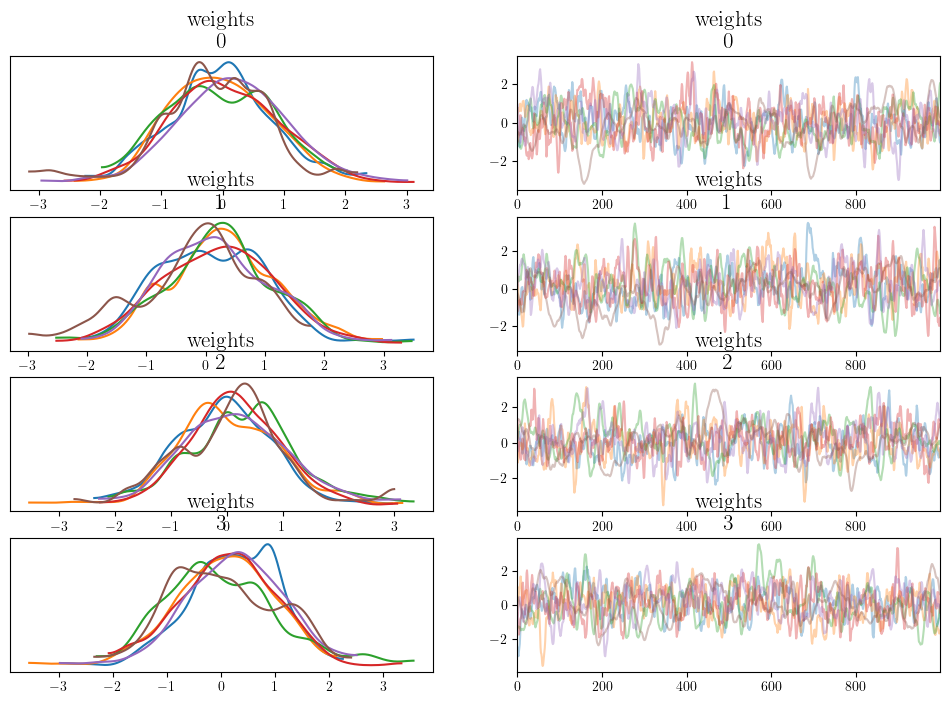

In [440]:
coords = {'weights_dim_0': jnp.arange(4)}
az.plot_trace(clean_samples, var_names=[
              'weights'], compact=False, combined=False, coords=coords)

In [441]:
samples.posterior.isnull()

<xarray.Dataset> Size: 6MB
Dimensions:        (chain: 10, draw: 1000, weights_dim_0: 625)
Coordinates:
  * chain          (chain) int64 80B 0 1 2 3 4 5 6 7 8 9
  * draw           (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * weights_dim_0  (weights_dim_0) int64 5kB 0 1 2 3 4 5 ... 620 621 622 623 624
Data variables:
    scale          (chain, draw) bool 10kB False False False ... False False
    weights        (chain, draw, weights_dim_0) bool 6MB False False ... False

In [442]:
samples.posterior.dropna(
    dim='chain', how='any').chain

<xarray.DataArray 'chain' (chain: 6)> Size: 48B
array([0, 3, 4, 7, 8, 9])
Coordinates:
  * chain    (chain) int64 48B 0 3 4 7 8 9

In [443]:
samples.posterior.sel(chain=9)

<xarray.Dataset> Size: 3MB
Dimensions:        (draw: 1000, weights_dim_0: 625)
Coordinates:
    chain          int64 8B 9
  * draw           (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * weights_dim_0  (weights_dim_0) int64 5kB 0 1 2 3 4 5 ... 620 621 622 623 624
Data variables:
    scale          (draw) float32 4kB 0.2245 0.2192 0.2013 ... 0.2232 0.2003
    weights        (draw, weights_dim_0) float32 2MB -0.5655 -0.2223 ... 0.2909
Attributes:
    created_at:     2024-11-04T16:21:55.710066+00:00
    arviz_version:  0.18.0

In [444]:
np.arange(0,10,2)

array([0, 2, 4, 6, 8])

In [445]:
def aZsamples_to_model_samples(az_samples):
    return {k: v.values for k, v in az_samples.posterior.items()}
aZsamples_to_model_samples(clean_samples.sel(draw=np.arange(0, num_draws, 10)))

{'scale': array([[0.21614575, 0.56541365, 0.3526883 , 0.2493384 , 1.95359   ,
         0.18111017, 0.2530405 , 0.60119087, 0.6254878 , 0.19754882,
         0.3666628 , 0.3232092 , 0.7715383 , 0.2778262 , 0.9512109 ,
         0.38253838, 0.3116647 , 0.37829515, 0.35104665, 0.22413026,
         0.6847032 , 0.45459956, 0.3128815 , 0.5868279 , 0.48555133,
         0.29665294, 0.6856706 , 0.3448692 , 1.0595653 , 0.23400243,
         0.19637801, 0.44877014, 0.75078094, 0.9500487 , 0.24698748,
         0.17631173, 0.21749012, 0.44225204, 0.5502187 , 0.6751952 ,
         0.47465   , 0.23547323, 0.41492257, 0.6798931 , 0.23043878,
         0.372262  , 0.5701575 , 0.5306231 , 1.8689666 , 0.83467656,
         0.21720745, 1.2036319 , 0.4185205 , 1.0076877 , 0.42536074,
         0.3148618 , 0.2743896 , 0.6197134 , 0.8856029 , 0.2830614 ,
         0.83283865, 0.5569795 , 0.27192873, 0.23681179, 0.26774797,
         0.2112767 , 0.37980455, 0.2562097 , 0.22330678, 0.11636387,
         0.51728344, 0.36

In [446]:
def aZsamples_to_model_samples(az_samples):
    return {k:v.values for k,v in az_samples.posterior.items()}

def prediction(key, x, posterior):
    num_chains = posterior['weights'].shape[0]
    sample_keys = jax.random.split(key, num_chains)

    def single_prediction_fn(rng_key, sample):
        rng_key, sample_key = random.split(rng_key)
        with handlers.seed(rng_seed=sample_key):
            cml = handlers.condition(bayes_model, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return rng_key, site['fn'].sample(sample_key)
    key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
        single_prediction_fn, key, sample))(sample_keys, posterior)
    return key[-1], preds


def prediction_mean(x, posterior):
    def single_prediction_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(bayes_model, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return site['fn'].loc
    preds = jax.vmap(lambda p: jax.lax.map(
        single_prediction_fn, p))(posterior)
    return preds

key = random.PRNGKey(0)
x_lin = jnp.linspace(-2.5, 2.5, 500).reshape(-1, 1)
key, preds = prediction(key, x_lin, aZsamples_to_model_samples(clean_samples.sel(draw=np.arange(0, num_draws, 10))))
preds.shape

(6, 100, 500)

In [447]:
# preds = prediction_mean(x_lin, aZsamples_to_model_samples(clean_samples))
# preds.shape

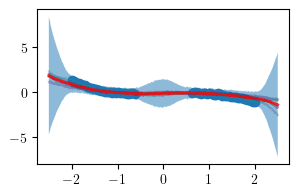

In [448]:
plt.plot(x, y, 'o', label='train')
colors = plt.cm.viridis(np.linspace(0,1,num_chains))
for o, c in zip(preds, colors):
    plt.plot(x_lin.squeeze(), o.mean(0), color=c, alpha=0.3)
plt.plot(x_lin.squeeze(), preds.mean(axis=(0, 1)), label='mean',
         c='red', linewidth=2, alpha=0.8)
plt.fill_between(x_lin.squeeze(), preds.mean(axis=(0,1)) - preds.std(axis=(0,1)), preds.mean(axis=(0,1)) + preds.std(axis=(0,1)), alpha=0.5)
pass

In [449]:
preds.shape

(6, 100, 500)

In [450]:
x_lin.size

500

In [451]:
np.savez('test_data_mcmc_elu10.npz', x=x_lin,
         y=preds)

### compare with Subspace approximation

Using t~U(0,1)


  0%|          | 0/10000 [00:00<?, ?it/s]

save tmp_files/7n2zd0xs_params
Save tmp_files/11_generate_data.npz


Curve length,▁▄▅▆▆▆▆▆▇▆▆▆▆▆▅▅▅▆▆▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
Curve valid_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
curve_log_likelihood,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Curve length,33.52322
Curve valid_loss,-1.37385
at_epoch,3186
best_loss,-1.54752
curve_log_likelihood,1.66267
epoch,9999


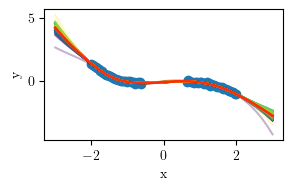

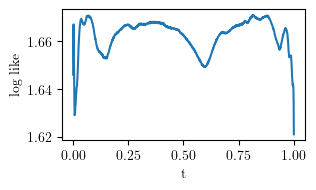

In [ ]:
from jax_sub_path_optim import single_run as single_run__path_optim

# config = {
#     'curve_params': {'k': 10,
#                      'model_kwargs': {'depth': 3, 'width': 10, 'activation': 'elu'},
#                      'n_samples': 10,
#                      'lr': 0.01,
#                      'num_epochs': 10000,
#                      'use_validation': True,
#                      'out_scale': 0.05,
#                      'optimize_distparams': True,
#                      'uniform_t_optimize': False,
#                      'bias_ascending_dnn': False
#                     },
#     'rng_seed': 10,
#     'dataset': 'generate',
# }
# config['curve_params']['bias_ascending_dnn'] = True
config['curve_params']['use_validation'] = False
logger = wandb.init(project="subspace_test", name="path_optim", entity="ddold", config=config)
single_run__path_optim(logger, config)

In [508]:
logger.id

'i8qx7aie'

Using exactly specified run ddold/subspace_test/7n2zd0xs
Control points in phi space: (21, 20)
space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)
Start warmup for mclmc
Warmup Wall time: 105.70 s
Start sampling ...
Sampling Wall time: 316.91 s
samples transformed
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
scale       0.057  0.011   0.039    0.077      0.000    0.000    7145.0   
t[0]        0.422  0.353   0.018    0.985      0.028    0.020     202.0   
tube[0]     0.032  0.367  -0.667    0.712      0.004    0.003    9971.0   
tube[1]    -0.011  0.406  -0.801    0.715      0.004    0.003   10053.0   
tube[2]     0.013  0.430  -0.814    0.798      0.004    0.003   10090.0   
tube[3]     0.009  0.414  -0.778    0.765      0.004    0.003   10586.0   
tube[4]     0.044  0.421  -0.758    0.815      0.004    0.003   10198.0   
tube[5]     0.017  0.445  -0.810    0.850      0.005    0.003    9527.0   
tube[6]     0.011  

/home/daniel/miniconda3/envs/jax_torch/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/daniel/miniconda3/envs/jax_torch/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (41), generating only 20 plots
  warnings.warn(


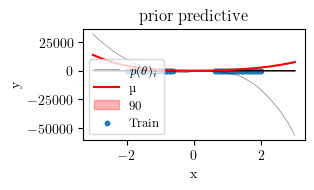

<Figure size 324.893x200.795 with 0 Axes>

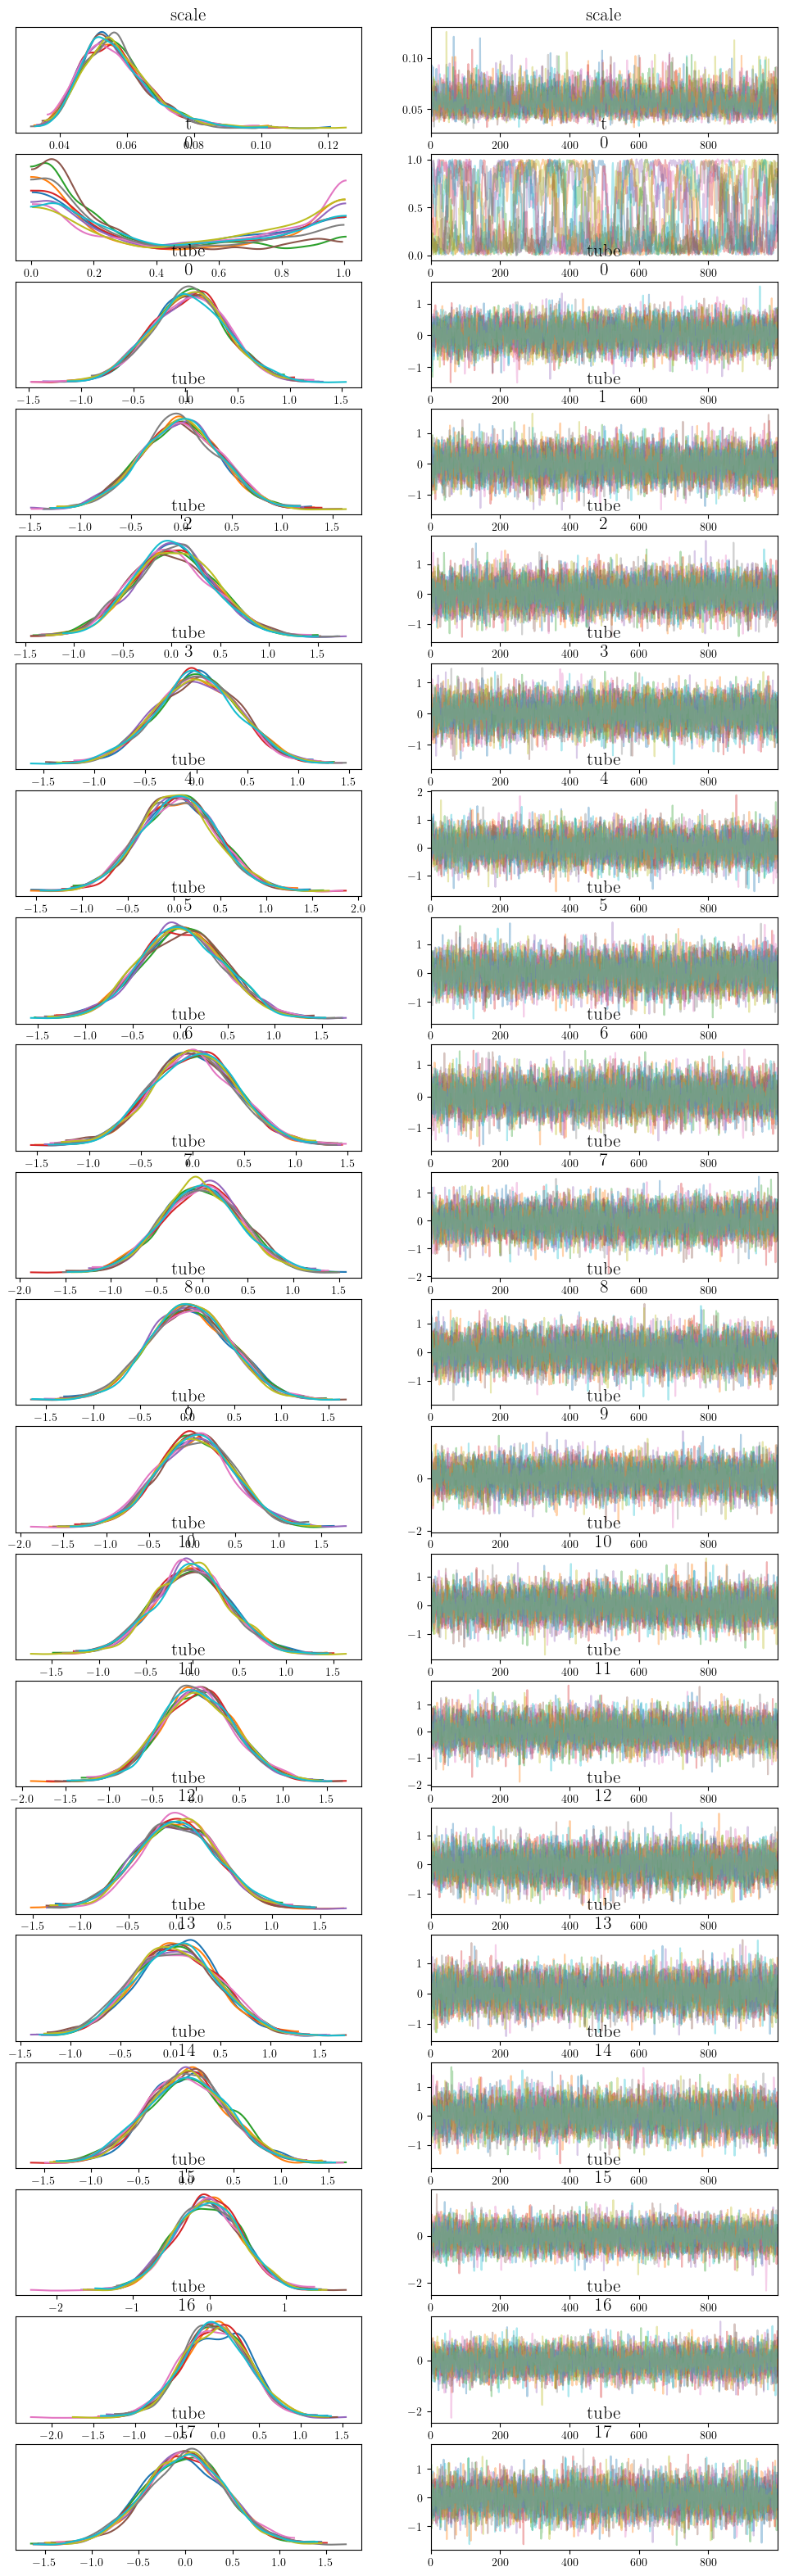

<Figure size 324.893x200.795 with 0 Axes>

<Figure size 324.893x200.795 with 0 Axes>

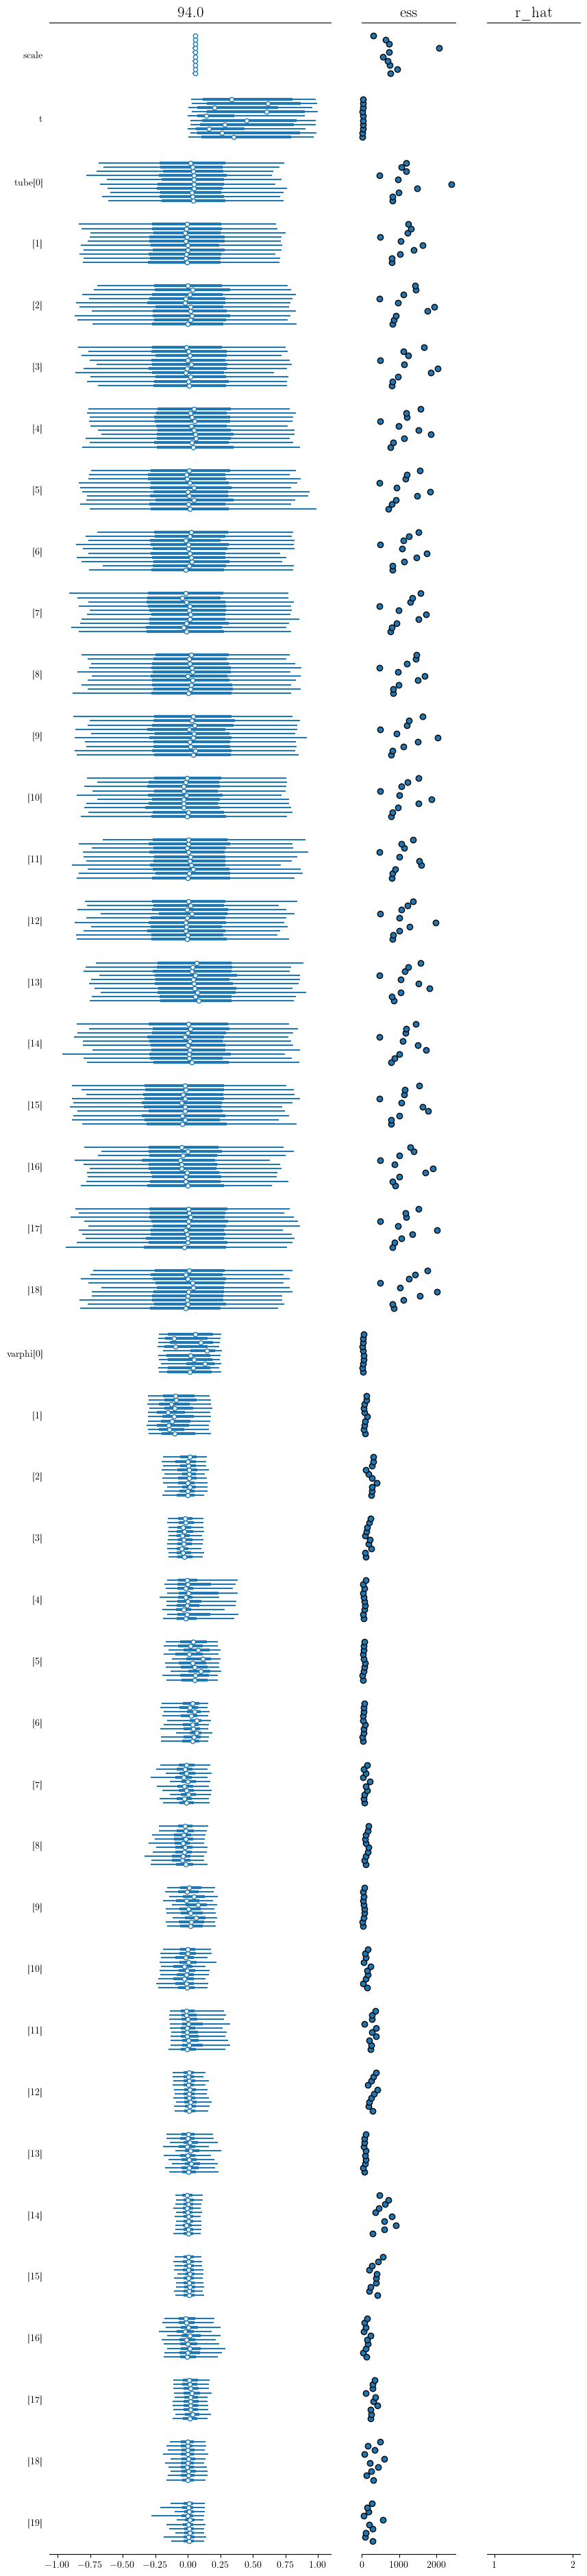

Save artifacts
Save samples
Save state
Log artifact
finish run


acceptance_rate,1.0
elpd_loo,98.557
elpd_test,0.03123
elpd_valid,1.49187
ess_mean,1360.8
ess_min,234.0
num_forward,100.0
p_loo,13.25884
r_hat_max,1.03
r_hat_mean,1.0115
rmse_test,0.2592


<Figure size 324.893x200.795 with 0 Axes>

In [546]:
from jax_sub_sampling_from_path import single_run as single_run_path_sampling

config['sampling'] =  {
                'space_config': 
                    {
                        'space': "lambda",
                        'prior_scale': 0.5,
                        'tube_scale': 0.1,
                        'epsilon': 25.0,
                        'prior_correct': False
                    },
                    # {
                    #     'space': "varphi",
                    #     'prior_scale': 1.0
                    # },
                'num_chains': 10,
                'temperature': 3.0,
                'num_warmup': 1000,
                'num_draws': 1000,
                'sampler': "mclmc",
                'num_forward_passes': 100
            }
config['path_sweep_id'] = logger.path

logger_sampling = wandb.init(project="subspace_test", name="path_sampling", entity="ddold", config=config)
single_run_path_sampling(logger_sampling, config)

#### load sampling model and samples

In [547]:
from src.utils import get_samples_from_run, get_model_from_run_path, get_data

# path = "ddold/subspace_test/s9wqqdz8"
# path = "ddold/subspace_test/ha12uiku"
path = logger_sampling.path
run = wandb.Api().run(path)

x, y, x_val, y_val, x_test_, y_test_ = get_data(run, from_path_optim_sweep=False)

In [548]:
az.summary(samples_approx)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,0.055,0.010,0.038,0.073,0.000,0.000,8913.0,9513.0,1.00
t[0],0.555,0.282,0.026,0.943,0.011,0.008,895.0,2819.0,1.01
tube[0],0.028,0.254,-0.447,0.515,0.002,0.002,14385.0,9197.0,1.00
tube[1],0.021,0.380,-0.725,0.694,0.003,0.003,16605.0,10178.0,1.00
tube[2],-0.020,0.371,-0.748,0.680,0.003,0.003,13630.0,10039.0,1.00
tube[3],-0.021,0.350,-0.662,0.669,0.003,0.002,13625.0,10159.0,1.00
tube[4],0.028,0.421,-0.739,0.842,0.003,0.003,15715.0,10062.0,1.00
tube[5],-0.027,0.408,-0.781,0.777,0.003,0.003,13936.0,10182.0,1.00
tube[6],0.030,0.344,-0.612,0.674,0.003,0.002,12609.0,10230.0,1.00
tube[7],0.046,0.386,-0.679,0.775,0.003,0.003,15315.0,10698.0,1.00


Num clean chains: 10


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale,0.057,0.011,0.039,0.077,0.000,0.000,7145.0,8688.0,1.00
t[0],0.422,0.353,0.018,0.985,0.028,0.020,202.0,866.0,1.04
tube[0],0.032,0.367,-0.667,0.712,0.004,0.003,9971.0,9438.0,1.00
tube[1],-0.011,0.406,-0.801,0.715,0.004,0.003,10053.0,9593.0,1.00
tube[2],0.013,0.430,-0.814,0.798,0.004,0.003,10090.0,9523.0,1.00
tube[3],0.009,0.414,-0.778,0.765,0.004,0.003,10586.0,9666.0,1.00
tube[4],0.044,0.421,-0.758,0.815,0.004,0.003,10198.0,9013.0,1.00
tube[5],0.017,0.445,-0.810,0.850,0.005,0.003,9527.0,9826.0,1.00
tube[6],0.011,0.422,-0.767,0.813,0.004,0.003,10208.0,9247.0,1.00
tube[7],-0.009,0.436,-0.841,0.796,0.004,0.003,9905.0,9750.0,1.00


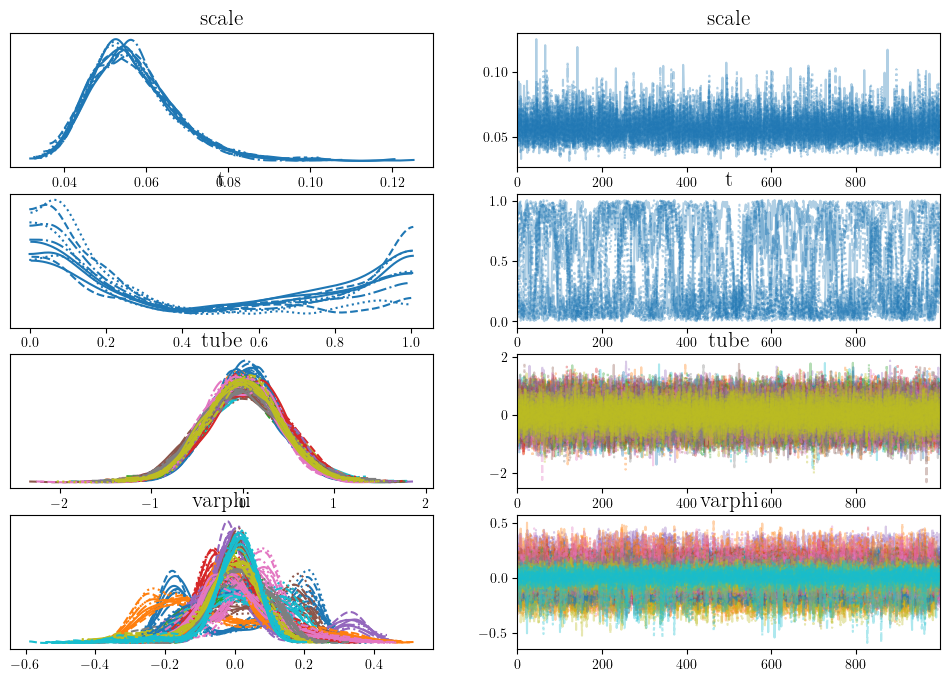

In [549]:
samples_approx = get_samples_from_run(run)

num_clean_chains = samples_approx.posterior.dropna(
    dim='chain', how='any').chain.size
print(f"Num clean chains: {num_clean_chains}")
if num_clean_chains == 0:
    print(f"No chains left")

samples_approx = az.InferenceData(
    posterior=samples_approx.posterior.dropna(dim='chain', how='any'))
az.plot_trace(samples_approx)
az.summary(samples_approx)

space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


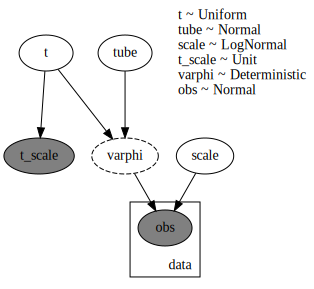

In [550]:
sampling_model, config, params = get_model_from_run_path(run)

def prediction(key, x, posterior):
    num_chains = posterior['scale'].shape[0]
    sample_keys = jax.random.split(key, num_chains)

    def single_prediction_fn(rng_key, sample):
        rng_key, sample_key = random.split(rng_key)
        with handlers.seed(rng_seed=sample_key):
            cml = handlers.condition(sampling_model, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return rng_key, site['fn'].sample(sample_key)
    key, preds = jax.vmap(lambda key, sample: jax.lax.scan(
        single_prediction_fn, key, sample))(sample_keys, posterior)
    return key[-1], preds


def prediction_mean(x, posterior):
    def single_prediction_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(sampling_model, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x, None, 1.)
            site = ex_trace['obs']
            return site['fn'].loc
    preds = jax.vmap(lambda p: jax.lax.map(
        single_prediction_fn, p))(posterior)
    return preds

numpyro.render_model(sampling_model, model_args=(x, y), render_distributions=True)

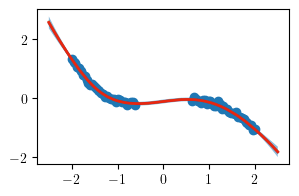

In [551]:
key = random.PRNGKey(0)
x_lin = jnp.linspace(-2.5, 2.5, 500).reshape(-1, 1)
key, preds = prediction(
    key, x_lin, aZsamples_to_model_samples(samples_approx))
preds.shape
# preds = prediction_mean(x_lin, aZsamples_to_model_samples(clean_samples))
# preds.shape
plt.plot(x, y, 'o', label='train')
colors = plt.cm.viridis(np.linspace(0, 1, num_chains))
for o, c in zip(preds, colors):
    plt.plot(x_lin.squeeze(), o.mean(0), color=c, alpha=0.3)
plt.plot(x_lin.squeeze(), preds.mean(axis=(0, 1)), label='mean',
         c='red', linewidth=2, alpha=0.8)
plt.fill_between(x_lin.squeeze(), preds.mean(axis=(0, 1)) - preds.std(axis=(0, 1)),
                 preds.mean(axis=(0, 1)) + preds.std(axis=(0, 1)), alpha=0.5)
pass

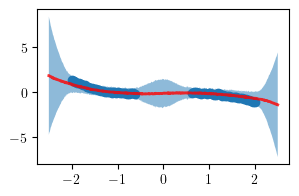

In [527]:
preds_mcmc = np.load('test_data_mcmc_elu10.npz')
plt.plot(x, y, 'o', label='train')

plt.plot(preds_mcmc['x'].squeeze(), preds_mcmc['y'].mean(axis=(0,1)), label='mean',
            c='red', linewidth=2, alpha=0.8)
plt.fill_between(preds_mcmc['x'].squeeze(), preds_mcmc['y'].mean(axis=(0,1)) - preds_mcmc['y'].std(axis=(0,1)),
                 preds_mcmc['y'].mean(axis=(0,1)) + preds_mcmc['y'].std(axis=(0,1)), alpha=0.5)

array([[<Axes: title={'center': 'scale'}>]], dtype=object)

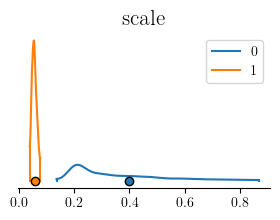

In [552]:
az.plot_density([clean_samples, samples_approx], var_names=['scale'])
# az.plot_density([clean_samples], var_names=['scale'])
# az.plot_density([samples_approx], var_names=['scale'])

In [542]:
def log_like_fn(x, y, posterior, model):
    def single_log_like_fn(sample):
        with handlers.seed(rng_seed=0):
            cml = handlers.condition(model, data=sample)
            ex_trace = handlers.trace(cml).get_trace(
                x)
            site = ex_trace['obs']
            log_like = site['fn'].log_prob(
                y)
            return log_like
            # return jax.device_put(log_like, jax.devices("cpu")[0])
    # return jax.vmap(jax.vmap(single_log_like_fn))(posterior)
    return jax.lax.map(lambda sample: jax.lax.map(single_log_like_fn, sample),posterior)
    # return jax.vmap(lambda sample: jax.lax.map(single_log_like_fn, sample))(posterior)

In [ ]:
log_like_mcmc = log_like_fn(x_lin, preds_mcmc['y'], aZsamples_to_model_samples(
    clean_samples.sel(draw=np.arange(0, num_draws, 10))), bayes_model)
print(log_like_mcmc.shape) # (num_chains, num_samples, *num_x) with num_x = (chain_mcmc, draws_mcmc, x_lin)

lppd_mcmc = jnp.mean(jax.scipy.special.logsumexp(
    log_like_mcmc, axis=((0,1))) - jnp.log(np.prod(log_like_mcmc.shape[0:2])))
print("Lppd MCMC: ", lppd_mcmc)

(6, 100, 6, 100, 500)
Lppd MCMC:  -1.0425918


In [ ]:
# log_like_approx = log_like_fn(x_lin, preds_mcmc['y'], aZsamples_to_model_samples(
#     samples_approx.sel(draw=np.arange(0, num_draws, 10))), sampling_model)
# print(log_like_approx.shape)

# lppd_approx = jnp.mean(jax.scipy.special.logsumexp(
#     log_like_approx, axis=((0, 1))) - jnp.log(np.prod(log_like_approx.shape[0:2])))
# lppd_approx

(10, 100, 6, 100, 500)


Array(-322.46054, dtype=float32)

In [ ]:
# log_like_approx = log_like_fn(x_lin, preds_mcmc['y'], aZsamples_to_model_samples(
#     samples_approx.sel(draw=np.arange(0, num_draws, 10))), sampling_model)
# print(log_like_approx.shape)

# lppd_approx = jnp.mean(jax.scipy.special.logsumexp(
#     log_like_approx, axis=((0, 1))) - jnp.log(np.prod(log_like_approx.shape[0:2])))
# lppd_approx

(9, 100, 6, 100, 500)


Array(-13.026397, dtype=float32)

In [553]:
log_like_approx = log_like_fn(x_lin, preds_mcmc['y'], aZsamples_to_model_samples(
    samples_approx.sel(draw=np.arange(0, num_draws, 10))), sampling_model)
print(log_like_approx.shape)

lppd_approx = jnp.mean(jax.scipy.special.logsumexp(
    log_like_approx, axis=((0, 1))) - jnp.log(np.prod(log_like_approx.shape[0:2])))

# add result to wandb
run.summary.update({'lppd_mcmc' : lppd_approx})
lppd_approx

(10, 100, 6, 100, 500)


Array(-123.7832, dtype=float32)